# Manticore-Local Cluster Posterior Catalog Demonstration

This notebook demonstrates how to work with the Manticore-Local cluster posterior catalog, which contains associations of dark matter halos identified in constrained cosmological simulations of the local universe.

## Data Source

- **Catalog**: `manticore_local_posterior_cluster_catalog.h5`
- **Download**: [www.cosmictwin.org](https://www.cosmictwin.org)
- **Publication describing posterior catalog**: [PLACEHOLDER: Insert catalog paper reference]
- **Manticore-Local Project paper**: [McAlpine et al. 2025, MNRAS 540, 716](https://ui.adsabs.harvard.edu/abs/2025MNRAS.540..716M/abstract)

## Catalog Structure
The HDF5 catalog contains two main groups:
- **`/summary/`**: Summary statistics (median, 25th, 75th percentiles) for each halo property across all associations
- **`/posterior/`**: Full posterior samples containing individual halo properties for each association

## Properties Stored

### Halo Properties
**Positions & Sizes** (all in Mpc):
- `BoundSubhalo_CentreOfMass`: 3D position of bound subhalo center
- `BoundSubhalo_EncloseRadius`: Radius enclosing bound particles
- `SO_200_crit_CentreOfMass`: Center of mass for R200 overdensity
- `SO_200_crit_SORadius`: R200 spherical overdensity radius
- `SO_500_crit_CentreOfMass`: Center of mass for R500 overdensity  
- `SO_500_crit_SORadius`: R500 spherical overdensity radius
- `dist`: Comoving distance from observer

**Masses** (all in M☉):
- `BoundSubhalo_TotalMass`: Total bound mass of subhalo
- `SO_200_crit_TotalMass`: M200 critical overdensity mass
- `SO_500_crit_TotalMass`: M500 critical overdensity mass

**Velocities** (in km/s):
- `BoundSubhalo_CentreOfMassVelocity`: 3D velocity of bound subhalo
- `BoundSubhalo_MaximumCircularVelocity`: Maximum circular velocity
- `SO_200_crit_CentreOfMassVelocity`: Velocity at R200
- `SO_500_crit_CentreOfMassVelocity`: Velocity at R500
- `vr`: Radial velocity

**Angular Coordinates** (all in degrees):
- `ra`: Right ascension
- `dec`: Declination  
- `gal_l`: Galactic longitude
- `gal_b`: Galactic latitude

**Dimensionless Properties**:
- `SO_200_crit_Concentration`: NFW concentration c200
- `SO_500_crit_Concentration`: NFW concentration c500
- `SO_200_crit_MassFractionSatellites`: Satellite mass fraction at R200
- `SO_200_crit_MassFractionExternal`: External mass fraction at R200
- `SO_500_crit_MassFractionSatellites`: Satellite mass fraction at R500
- `SO_500_crit_MassFractionExternal`: External mass fraction at R500

**Metadata**:
- `association_id`: Unique identifier for each association
- `cluster_size`: Number of member halos in association
- `SOAP_ProjectorIndex`: SOAP halo finder index
- `SOAP_SubhaloRankByBoundMass`: Subhalo rank by bound mass

## What We'll Demonstrate
1. **Loading the catalog** and understanding its hierarchical structure
2. **Visualizing association positions** using the summary statistics (RA/Dec sky distribution)
3. **Accessing posterior samples** for individual associations
4. **Analyzing halo properties** within associations (M200 mass and concentration distributions)
5. **Comparing associations** to understand population variations

The catalog enables both population-level analyses using summary statistics and detailed investigation of individual associations using the full posterior samples.

In [3]:
# Cell 1: Load the catalog data
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the catalog file (be sure to update this with your path)
catalog_path = "manticore_local_posterior_cluster_catalog.h5"

with h5py.File(catalog_path, 'r') as f:
    # Load summary data
    association_ids = f['summary/association_id'][:]
    cluster_sizes = f['summary/cluster_size'][:]
    
    # Load median positions (RA/Dec)
    ra_summary = f['summary/ra'][:]  # Shape: (n_clusters, 3) for median/p25/p75
    dec_summary = f['summary/dec'][:]
    
    # Print file structure
    print("Catalog structure:")
    print(f"  Number of associations: {len(association_ids)}")
    print(f"  Association IDs: {association_ids[:10]}...")
    print(f"  Cluster sizes: min={cluster_sizes.min()}, max={cluster_sizes.max()}, mean={cluster_sizes.mean():.1f}")
    print(f"\nAvailable summary properties: {list(f['summary'].keys())[:10]}...")
    print(f"Available associations in posterior: {len(f['posterior'].keys())}")

Catalog structure:
  Number of associations: 225
  Association IDs: [ 10 101 104 106 109  11 110 111 112 113]...
  Cluster sizes: min=40, max=80, mean=59.7

Available summary properties: ['BoundSubhalo_CentreOfMass', 'BoundSubhalo_CentreOfMassVelocity', 'BoundSubhalo_EncloseRadius', 'BoundSubhalo_MaximumCircularVelocity', 'BoundSubhalo_TotalMass', 'SOAP_ProgenitorIndex', 'SOAP_SubhaloRankByBoundMass', 'SO_200_crit_CentreOfMass', 'SO_200_crit_CentreOfMassVelocity', 'SO_200_crit_Concentration']...
Available associations in posterior: 225


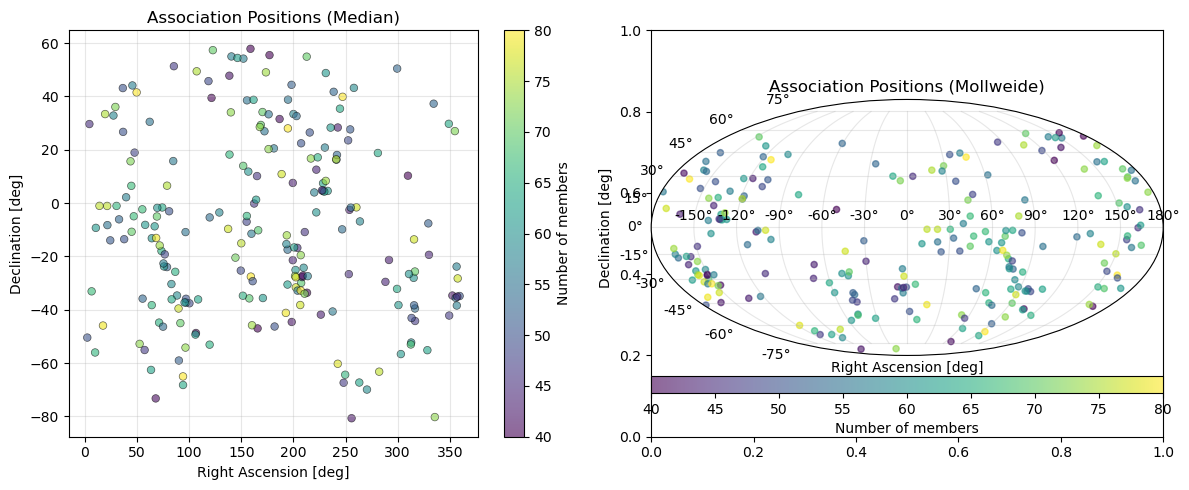

Position statistics:
  RA range: 2.2° - 359.4°
  Dec range: -80.7° - 57.9°


In [4]:
# Cell 2: Plot median positions of associations in RA/Dec
import matplotlib.pyplot as plt

# Extract median RA and Dec (first column is median)
median_ra = ra_summary[:, 0]  
median_dec = dec_summary[:, 0]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: Standard scatter plot
scatter = ax1.scatter(median_ra, median_dec, c=cluster_sizes, 
                      cmap='viridis', s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Right Ascension [deg]')
ax1.set_ylabel('Declination [deg]')
ax1.set_title('Association Positions (Median)')
plt.colorbar(scatter, ax=ax1, label='Number of members')
ax1.grid(True, alpha=0.3)

# Right: Mollweide projection
ax2 = plt.subplot(122, projection='mollweide')

# Convert RA to [-180, 180] for Mollweide
ra_wrapped = np.where(median_ra > 180, median_ra - 360, median_ra)
ra_rad = np.radians(ra_wrapped)
dec_rad = np.radians(median_dec)

scatter2 = ax2.scatter(ra_rad, dec_rad, c=cluster_sizes, 
                       cmap='viridis', s=20, alpha=0.6)
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('Right Ascension [deg]')
ax2.set_ylabel('Declination [deg]')
ax2.set_title('Association Positions (Mollweide)')

# Set xticks in radians with degree labels
tick_labels = np.arange(-150, 181, 30)
ax2.set_xticks(np.radians(tick_labels))
ax2.set_xticklabels([f"{tl}°" for tl in tick_labels])

plt.colorbar(scatter2, ax=ax2, label='Number of members', 
             orientation='horizontal', pad=0.05, aspect=30)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Position statistics:")
print(f"  RA range: {median_ra.min():.1f}° - {median_ra.max():.1f}°")
print(f"  Dec range: {median_dec.min():.1f}° - {median_dec.max():.1f}°")

In [5]:
# Cell 3: Select an example association and load its posterior data
# Choose the largest association as example
example_idx = np.argmax(cluster_sizes)
example_id = association_ids[example_idx]
example_size = cluster_sizes[example_idx]

print(f"Selected association {example_id} with {example_size} members")

# Load posterior data for this association
with h5py.File(catalog_path, 'r') as f:
    association_grp = f[f'posterior/association_{example_id}']
    
    # Load M200 masses and concentrations
    m200_masses = association_grp['SO_200_crit_TotalMass'][:]
    concentrations = association_grp['SO_200_crit_Concentration'][:]
    
    # Get association metadata
    mean_m200 = association_grp.attrs['mean_m200_mass']
    mean_position = association_grp.attrs['mean_position']
    
print(f"Association {example_id} properties:")
print(f"  Mean M200 mass: {mean_m200:.2e} M☉")
print(f"  Mean position: [{mean_position[0]:.1f}, {mean_position[1]:.1f}, {mean_position[2]:.1f}] Mpc")
print(f"  M200 range: {m200_masses.min():.2e} - {m200_masses.max():.2e} M☉")
print(f"  Concentration range: {concentrations.min():.1f} - {concentrations.max():.1f}")

Selected association 106 with 80 members
Association 106 properties:
  Mean M200 mass: 3.24e+14 M☉
  Mean position: [447.1, 520.2, 470.4] Mpc
  M200 range: 2.03e+14 - 4.77e+14 M☉
  Concentration range: 1.0 - 7.7


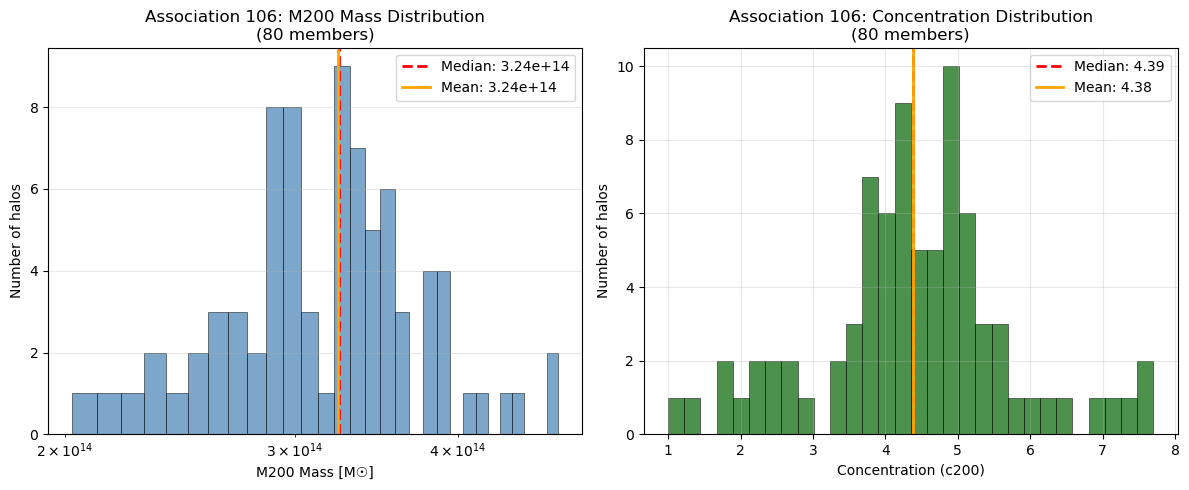


M200 Mass percentiles:
  10th: 2.59e+14 M☉
  25th: 2.88e+14 M☉
  50th: 3.24e+14 M☉
  75th: 3.53e+14 M☉
  90th: 3.90e+14 M☉

Concentration percentiles:
  10th: 2.45
  25th: 3.75
  50th: 4.39
  75th: 5.06
  90th: 5.80


In [6]:
# Cell 4: Plot posterior distributions of M200 mass and concentration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: M200 mass distribution
ax1.hist(m200_masses, bins=30, alpha=0.7, color='steelblue', 
         edgecolor='black', linewidth=0.5)
ax1.axvline(np.median(m200_masses), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {np.median(m200_masses):.2e}')
ax1.axvline(mean_m200, color='orange', linestyle='-', 
            linewidth=2, label=f'Mean: {mean_m200:.2e}')
ax1.set_xlabel('M200 Mass [M☉]')
ax1.set_ylabel('Number of halos')
ax1.set_title(f'Association {example_id}: M200 Mass Distribution\n({example_size} members)')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Concentration distribution
ax2.hist(concentrations, bins=30, alpha=0.7, color='darkgreen', 
         edgecolor='black', linewidth=0.5)
ax2.axvline(np.median(concentrations), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {np.median(concentrations):.2f}')
ax2.axvline(np.mean(concentrations), color='orange', linestyle='-', 
            linewidth=2, label=f'Mean: {np.mean(concentrations):.2f}')
ax2.set_xlabel('Concentration (c200)')
ax2.set_ylabel('Number of halos')
ax2.set_title(f'Association {example_id}: Concentration Distribution\n({example_size} members)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print percentile statistics
print(f"\nM200 Mass percentiles:")
print(f"  10th: {np.percentile(m200_masses, 10):.2e} M☉")
print(f"  25th: {np.percentile(m200_masses, 25):.2e} M☉")
print(f"  50th: {np.percentile(m200_masses, 50):.2e} M☉")
print(f"  75th: {np.percentile(m200_masses, 75):.2e} M☉")
print(f"  90th: {np.percentile(m200_masses, 90):.2e} M☉")

print(f"\nConcentration percentiles:")
print(f"  10th: {np.percentile(concentrations, 10):.2f}")
print(f"  25th: {np.percentile(concentrations, 25):.2f}")
print(f"  50th: {np.percentile(concentrations, 50):.2f}")
print(f"  75th: {np.percentile(concentrations, 75):.2f}")
print(f"  90th: {np.percentile(concentrations, 90):.2f}")

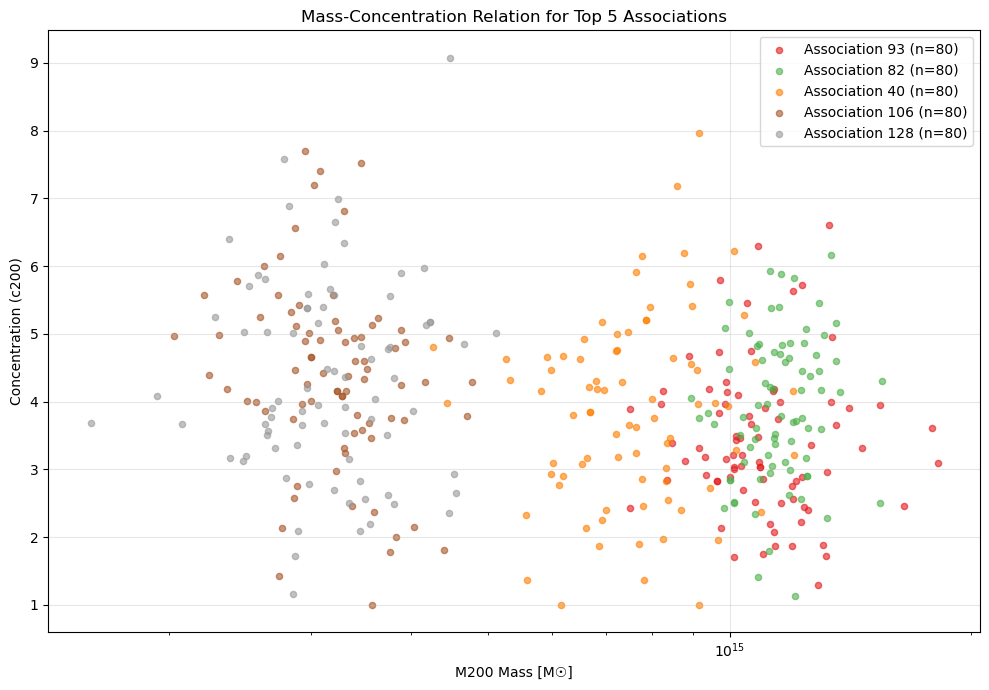

In [7]:
# Cell 5: Compare multiple associations - mass vs concentration scatter
# Select top 5 largest associations for comparison
top_n = 5
top_indices = np.argsort(cluster_sizes)[-top_n:][::-1]

fig, ax = plt.subplots(figsize=(10, 7))

colors = plt.cm.Set1(np.linspace(0, 1, top_n))

with h5py.File(catalog_path, 'r') as f:
    for i, idx in enumerate(top_indices):
        assoc_id = association_ids[idx]
        assoc_size = cluster_sizes[idx]
        
        # Load data for this association
        association_grp = f[f'posterior/association_{assoc_id}']
        masses = association_grp['SO_200_crit_TotalMass'][:]
        concs = association_grp['SO_200_crit_Concentration'][:]
        
        # Plot scatter
        ax.scatter(masses, concs, alpha=0.6, s=20, color=colors[i], 
                  label=f'Association {assoc_id} (n={assoc_size})')

ax.set_xlabel('M200 Mass [M☉]')
ax.set_ylabel('Concentration (c200)')
ax.set_title('Mass-Concentration Relation for Top 5 Associations')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()